In [1]:
!pip install terminaltables

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
import datetime
import os
import sys
from terminaltables import AsciiTable
import time
import torch
from torch.autograd import Variable
from torch.backends import cudnn
from torch.utils import data
import torchvision

In [3]:
sys.path.append('/WorkSpace/PrivacyGAN/common/')
sys.path.append('/WorkSpace/PrivacyGAN/models/')

In [4]:
from yolov3 import Darknet
import utility as utils
from datasets import ListDataset, evaluate
from logger import Logger

from pix2pix import define_G, define_D, GANLoss

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

In [6]:
use_cuda

True

In [7]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

BASE_PATH = '/data/Waymo'
TRAIN_PATH = os.path.join(BASE_PATH, 'yolov3_train')
TEST_PATH = os.path.join(BASE_PATH, 'yolov3_test')

PROJECT_BASE = '/WorkSpace/PrivacyGAN/'
DATA_CONFIG_0 = os.path.join(PROJECT_BASE, 'models/yolov3_0.data')
DATA_CONFIG_1 = os.path.join(PROJECT_BASE, 'models/yolov3_1.data')
YOLO_CONFIG = os.path.join(PROJECT_BASE, 'models/yolov3-tiny.cfg')

In [8]:
data_config_0 = utils.parse_data_config(DATA_CONFIG_0)
data_config_1 = utils.parse_data_config(DATA_CONFIG_1)
train_path = data_config_0['train']
valid_path = data_config_0['valid']
class_names_0 = utils.load_classes(data_config_0['names'])
class_names_1 = utils.load_classes(data_config_1['names'])

In [9]:
class_names_0, class_names_1

(['pedestrian'], ['vehicle'])

In [10]:
data_config_0, data_config_1

({'gpus': '0,1,2,3',
  'num_workers': '10',
  'classes': '1',
  'train': '/data/Waymo/128x128/train.txt',
  'valid': '/data/Waymo/128x128/valid.txt',
  'names': '/data/Waymo/128x128/classes0.names',
  'datapath': '/data/Waymo/128x128',
  'label': 'yolov3_0'},
 {'gpus': '0,1,2,3',
  'num_workers': '10',
  'classes': '1',
  'train': '/data/Waymo/128x128/train.txt',
  'valid': '/data/Waymo/128x128/valid.txt',
  'names': '/data/Waymo/128x128/classes1.names',
  'datapath': '/data/Waymo/128x128',
  'label': 'yolov3_1'})

In [11]:
net_g = define_G(3, 3, 64, 'batch', False, 'normal', 0.02, gpu_id=device)
net_d = define_D(3, 64, 'basic', gpu_id=device)

initialize network with normal
initialize network with normal


In [12]:
model_0 = Darknet(YOLO_CONFIG).to(device)
model_1 = Darknet(YOLO_CONFIG).to(device)

model_0.apply(utils.weights_init_normal)
model_1.apply(utils.weights_init_normal)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.9, aff

In [13]:
MULTISCALE = False
BATCH_SIZE = 8
N_CPU = 8

In [14]:
from PIL import Image

In [15]:
train_dataset = ListDataset(train_path, data_config_0['label'], data_config_1['label'], augment=True, multiscale=MULTISCALE)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU,
    pin_memory=False,
    collate_fn=train_dataset.collate_fn,
)

In [16]:
valid_dataset = ListDataset(valid_path, data_config_0['label'], data_config_1['label'], augment=False, multiscale=False)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_CPU,
    pin_memory=False,
    collate_fn=train_dataset.collate_fn,
)

In [17]:
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(net_d.parameters(), lr=0.00001, betas=(0.5, 0.999))
criterionGAN = GANLoss().to(device)
criterionL1 = torch.nn.L1Loss().to(device)
criterionMSE = torch.nn.MSELoss().to(device)

In [18]:
optimizer_0 = torch.optim.Adam(model_0.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.00001, betas=(0.5, 0.999))
metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

In [19]:
EPOCHS = 100
IMAGE_SIZE=128

In [20]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
warnings.simplefilter("ignore")
h_epochs = []
h_valid_losses_g = []
h_train_losses_g = []
h_valid_losses_d = []
h_train_losses_d = []
h_valid_losses_0 = []
h_train_losses_0 = []
h_valid_losses_1 = []
h_train_losses_1 = []

100%|██████████| 672/672 [05:14<00:00,  2.13it/s]


---- [D:Epoch 0/100, Batch 671/672] ----

Total loss g -4.012153625488281
Total loss 0 62.465728759765625
Total loss 1 66.4778823852539

---- Evaluating Model ----



 92%|█████████▏| 145/158 [00:13<00:01, 10.39it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


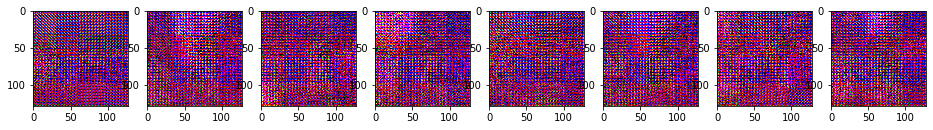

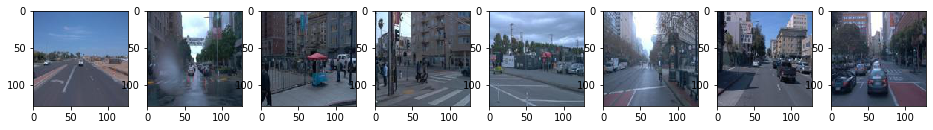

100%|██████████| 158/158 [00:16<00:00,  9.55it/s]


---- [A:Epoch 0/100, Evaluation] ----

Total loss g -3.088489097884939
Total loss 0 63.24389216266101
Total loss 1 66.33238126054594



100%|██████████| 672/672 [05:09<00:00,  2.17it/s]


---- [D:Epoch 1/100, Batch 671/672] ----

Total loss g -1.0891838073730469
Total loss 0 38.767948150634766
Total loss 1 39.85713195800781

---- Evaluating Model ----



 87%|████████▋ | 138/158 [00:13<00:01, 10.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


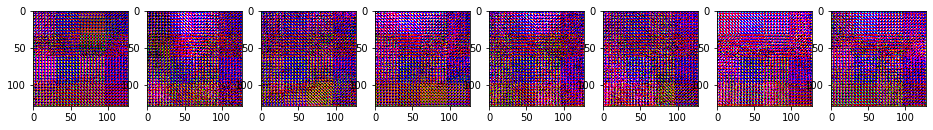

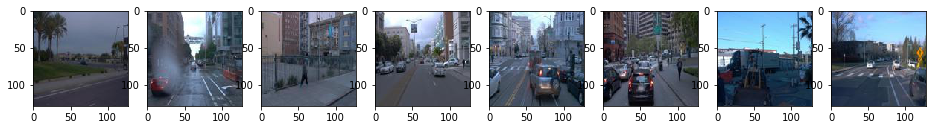

100%|██████████| 158/158 [00:16<00:00,  9.35it/s]


---- [A:Epoch 1/100, Evaluation] ----

Total loss g -2.081728657589683
Total loss 0 38.32934548583212
Total loss 1 40.4110741434218



100%|██████████| 672/672 [05:13<00:00,  2.14it/s]


---- [D:Epoch 2/100, Batch 671/672] ----

Total loss g -3.015094757080078
Total loss 0 24.899856567382812
Total loss 1 27.91495132446289

---- Evaluating Model ----



 88%|████████▊ | 139/158 [00:13<00:01, 10.39it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


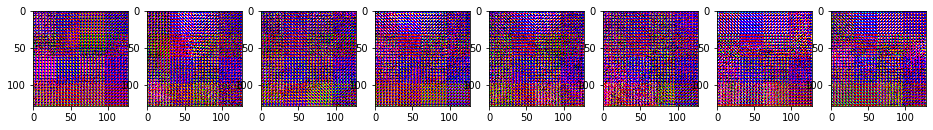

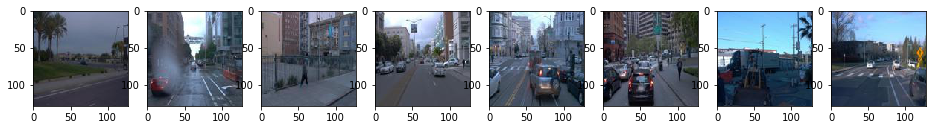

100%|██████████| 158/158 [00:16<00:00,  9.74it/s]


---- [A:Epoch 2/100, Evaluation] ----

Total loss g -1.4690137814871873
Total loss 0 26.19544728194611
Total loss 1 27.664461063433297



100%|██████████| 672/672 [05:09<00:00,  2.17it/s]


---- [D:Epoch 3/100, Batch 671/672] ----

Total loss g -2.711803436279297
Total loss 0 17.998394012451172
Total loss 1 20.71019744873047

---- Evaluating Model ----



 54%|█████▍    | 86/158 [00:08<00:06, 10.45it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


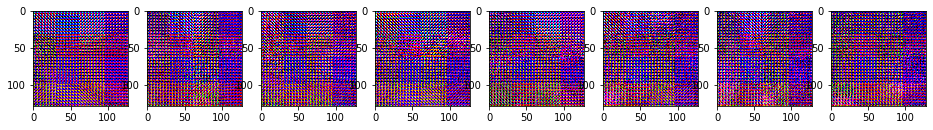

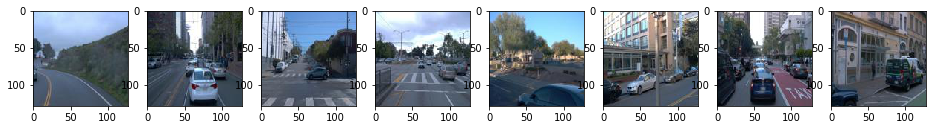

100%|██████████| 158/158 [00:16<00:00,  9.34it/s]


---- [A:Epoch 3/100, Evaluation] ----

Total loss g -1.2893534551692913
Total loss 0 19.46257784396787
Total loss 1 20.751931299137162



100%|██████████| 672/672 [05:13<00:00,  2.15it/s]


---- [D:Epoch 4/100, Batch 671/672] ----

Total loss g -3.930828094482422
Total loss 0 14.346614837646484
Total loss 1 18.277442932128906

---- Evaluating Model ----



 97%|█████████▋| 153/158 [00:14<00:00, 10.86it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


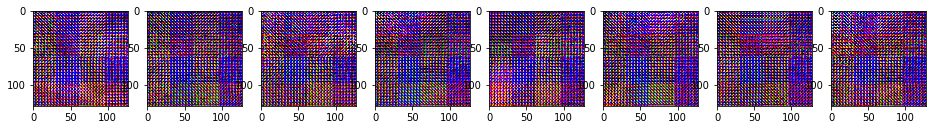

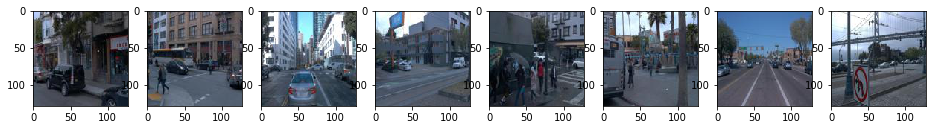

100%|██████████| 158/158 [00:16<00:00,  9.69it/s]


---- [A:Epoch 4/100, Evaluation] ----

Total loss g -1.3031770669961278
Total loss 0 15.451450414295438
Total loss 1 16.754627481291564



100%|██████████| 672/672 [05:15<00:00,  2.13it/s]


---- [D:Epoch 5/100, Batch 671/672] ----

Total loss g -3.753091812133789
Total loss 0 11.852441787719727
Total loss 1 15.605533599853516

---- Evaluating Model ----



 12%|█▏        | 19/158 [00:01<00:13, 10.08it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


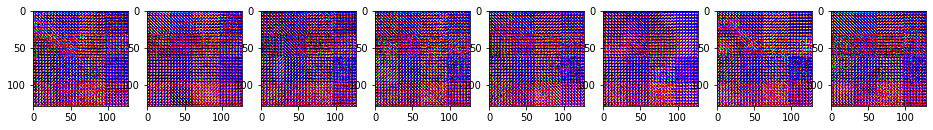

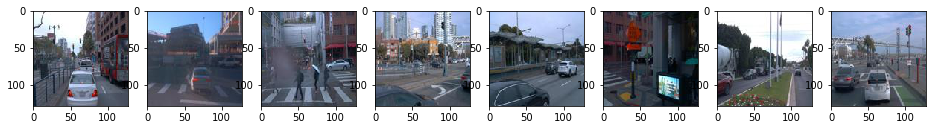

100%|██████████| 158/158 [00:16<00:00,  9.63it/s]


---- [A:Epoch 5/100, Evaluation] ----

Total loss g -1.498247967490667
Total loss 0 12.914358471013323
Total loss 1 14.412606438503989



100%|██████████| 672/672 [05:14<00:00,  2.14it/s]


---- [D:Epoch 6/100, Batch 671/672] ----

Total loss g -1.841904640197754
Total loss 0 10.0861177444458
Total loss 1 11.928022384643555

---- Evaluating Model ----



 13%|█▎        | 21/158 [00:02<00:13, 10.22it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


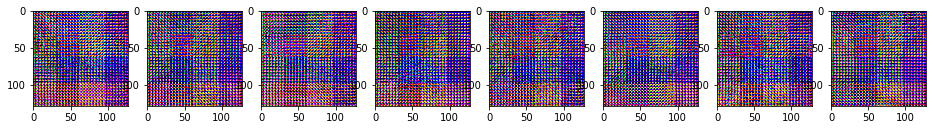

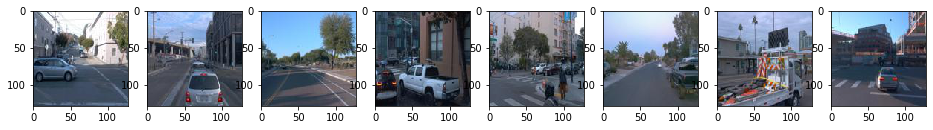

100%|██████████| 158/158 [00:16<00:00,  9.73it/s]


---- [A:Epoch 6/100, Evaluation] ----

Total loss g -1.7166006293477891
Total loss 0 11.146054352386088
Total loss 1 12.862654981733877



100%|██████████| 672/672 [05:15<00:00,  2.13it/s]


---- [D:Epoch 7/100, Batch 671/672] ----

Total loss g -1.085580825805664
Total loss 0 10.61998176574707
Total loss 1 11.705562591552734

---- Evaluating Model ----



 85%|████████▌ | 135/158 [00:12<00:02, 10.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


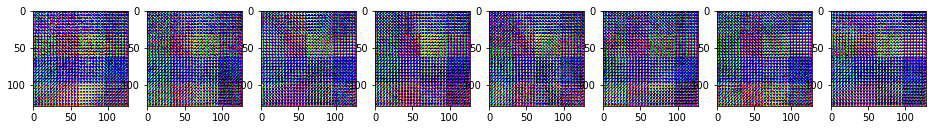

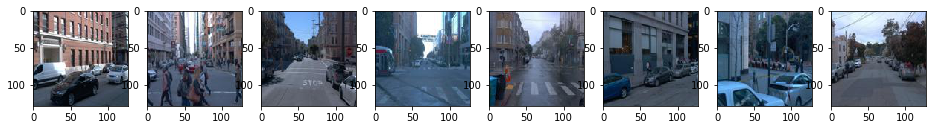

100%|██████████| 158/158 [00:16<00:00,  9.64it/s]


---- [A:Epoch 7/100, Evaluation] ----

Total loss g -1.8684640956830374
Total loss 0 9.921407029598575
Total loss 1 11.789871125281612



100%|██████████| 672/672 [05:15<00:00,  2.13it/s]


---- [D:Epoch 8/100, Batch 671/672] ----

Total loss g -3.189450263977051
Total loss 0 8.491898536682129
Total loss 1 11.68134880065918

---- Evaluating Model ----



 97%|█████████▋| 153/158 [00:14<00:00, 11.00it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


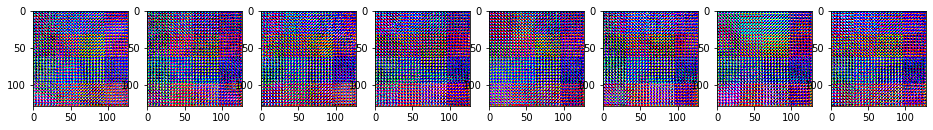

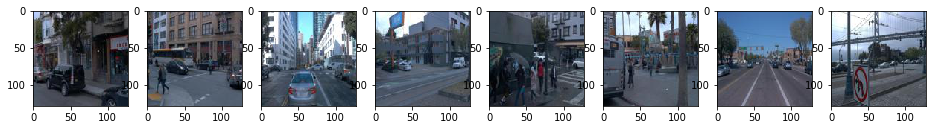

100%|██████████| 158/158 [00:16<00:00,  9.75it/s]


---- [A:Epoch 8/100, Evaluation] ----

Total loss g -2.1043241627608675
Total loss 0 9.094294309616089
Total loss 1 11.198618472376957



100%|██████████| 672/672 [05:15<00:00,  2.13it/s]


---- [D:Epoch 9/100, Batch 671/672] ----

Total loss g -2.727405548095703
Total loss 0 8.21612548828125
Total loss 1 10.943531036376953

---- Evaluating Model ----



 48%|████▊     | 76/158 [00:07<00:07, 10.58it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


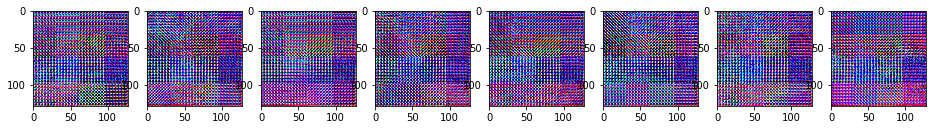

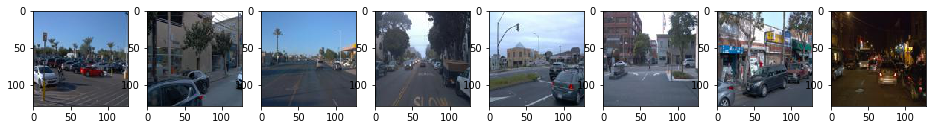

100%|██████████| 158/158 [00:16<00:00,  9.60it/s]


---- [A:Epoch 9/100, Evaluation] ----

Total loss g -2.3381587312191345
Total loss 0 8.431878316251538
Total loss 1 10.770037047470673



100%|██████████| 672/672 [05:14<00:00,  2.14it/s]


---- [D:Epoch 10/100, Batch 671/672] ----

Total loss g -1.7297306060791016
Total loss 0 7.198822021484375
Total loss 1 8.928552627563477

---- Evaluating Model ----



  9%|▉         | 15/158 [00:01<00:14, 10.20it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


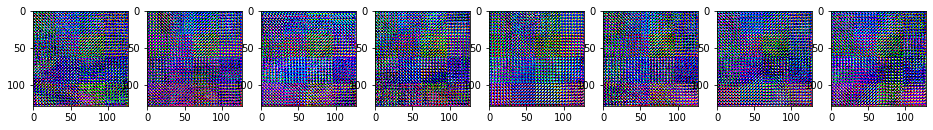

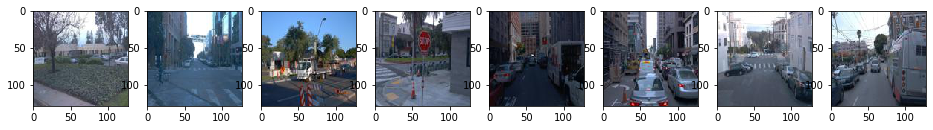

100%|██████████| 158/158 [00:16<00:00,  9.71it/s]


---- [A:Epoch 10/100, Evaluation] ----

Total loss g -2.26787284657925
Total loss 0 8.097315426114239
Total loss 1 10.365188272693489



100%|██████████| 672/672 [05:13<00:00,  2.14it/s]


---- [D:Epoch 11/100, Batch 671/672] ----

Total loss g -2.9499998092651367
Total loss 0 6.225035667419434
Total loss 1 9.17503547668457

---- Evaluating Model ----



 17%|█▋        | 27/158 [00:02<00:12, 10.51it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


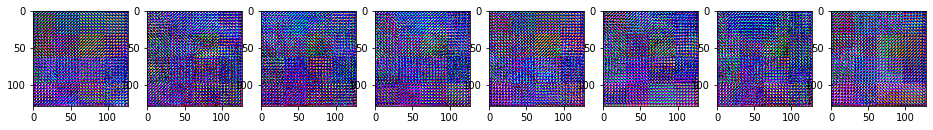

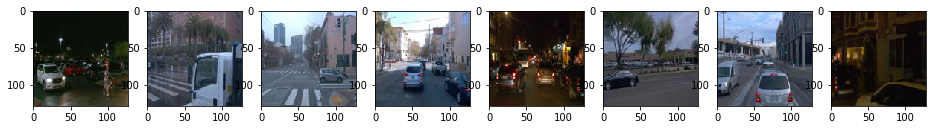

100%|██████████| 158/158 [00:16<00:00,  9.62it/s]


---- [A:Epoch 11/100, Evaluation] ----

Total loss g -2.4393379024312467
Total loss 0 7.7132521611225755
Total loss 1 10.152590063553822



100%|██████████| 672/672 [05:16<00:00,  2.13it/s]


---- [D:Epoch 12/100, Batch 671/672] ----

Total loss g -5.8267927169799805
Total loss 0 6.337273597717285
Total loss 1 12.164066314697266

---- Evaluating Model ----



 18%|█▊        | 29/158 [00:02<00:12, 10.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


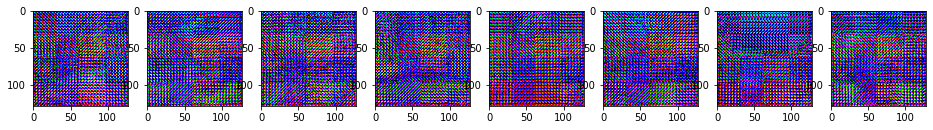

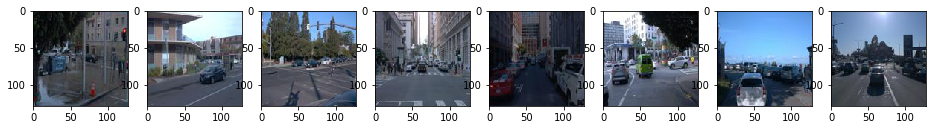

100%|██████████| 158/158 [00:16<00:00,  9.70it/s]


---- [A:Epoch 12/100, Evaluation] ----

Total loss g -2.5255204001559486
Total loss 0 7.4865732253352295
Total loss 1 10.012093625491179



100%|██████████| 672/672 [05:15<00:00,  2.13it/s]


---- [D:Epoch 13/100, Batch 671/672] ----

Total loss g -3.6217708587646484
Total loss 0 6.575042724609375
Total loss 1 10.196813583374023

---- Evaluating Model ----



 29%|██▉       | 46/158 [00:04<00:10, 10.97it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


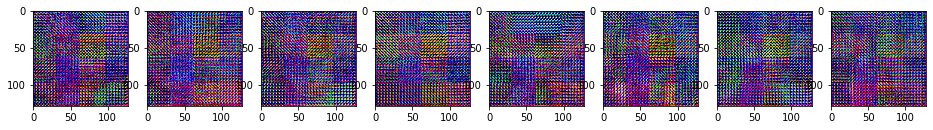

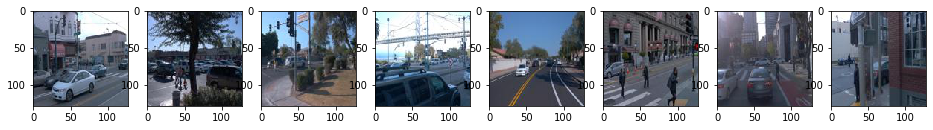

100%|██████████| 158/158 [00:16<00:00,  9.66it/s]


---- [A:Epoch 13/100, Evaluation] ----

Total loss g -2.6756751748579966
Total loss 0 7.258362429051459
Total loss 1 9.934037603909456



100%|██████████| 672/672 [05:14<00:00,  2.14it/s]


---- [D:Epoch 14/100, Batch 671/672] ----

Total loss g -2.5244178771972656
Total loss 0 6.769742965698242
Total loss 1 9.294160842895508

---- Evaluating Model ----



 56%|█████▋    | 89/158 [00:08<00:06, 10.65it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


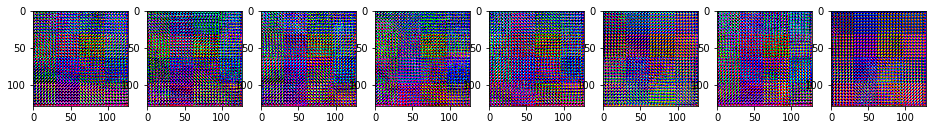

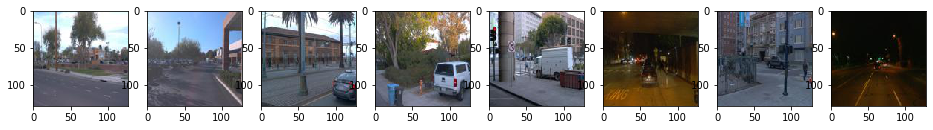

100%|██████████| 158/158 [00:16<00:00,  9.71it/s]


---- [A:Epoch 14/100, Evaluation] ----

Total loss g -2.617385779755025
Total loss 0 7.137743702417688
Total loss 1 9.755129482172713



100%|██████████| 672/672 [05:15<00:00,  2.13it/s]


---- [D:Epoch 15/100, Batch 671/672] ----

Total loss g -4.233468055725098
Total loss 0 7.484362602233887
Total loss 1 11.717830657958984

---- Evaluating Model ----



  1%|▏         | 2/158 [00:00<00:19,  7.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


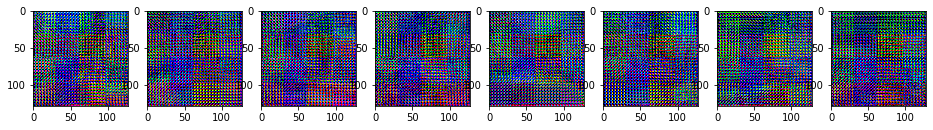

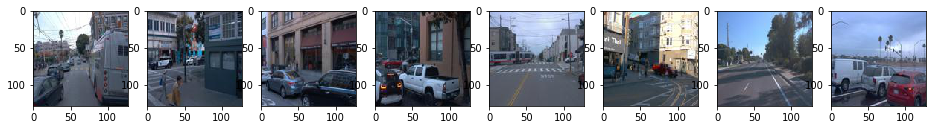

100%|██████████| 158/158 [00:16<00:00,  9.68it/s]


---- [A:Epoch 15/100, Evaluation] ----

Total loss g -2.759598092187809
Total loss 0 6.969221776044821
Total loss 1 9.72881986823263



100%|██████████| 672/672 [05:15<00:00,  2.13it/s]


---- [D:Epoch 16/100, Batch 671/672] ----

Total loss g -2.735520362854004
Total loss 0 5.837540626525879
Total loss 1 8.573060989379883

---- Evaluating Model ----



 60%|██████    | 95/158 [00:09<00:06, 10.37it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


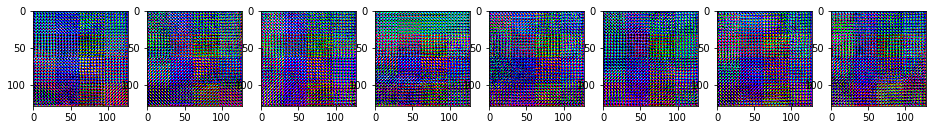

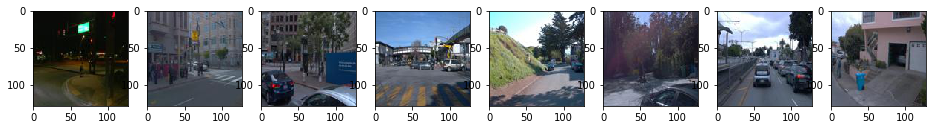

100%|██████████| 158/158 [00:16<00:00,  9.77it/s]


---- [A:Epoch 16/100, Evaluation] ----

Total loss g -2.7567960944356797
Total loss 0 6.855779364139219
Total loss 1 9.612575458574899



 10%|█         | 69/672 [00:32<04:48,  2.09it/s]

In [ ]:
for epoch in range(EPOCHS):
    model_0.train()
    model_1.train()
    
    net_d.train()    
    net_g.train()
    start_time = time.time()
    
    for batch_i, (_, imgs, targets_0, targets_1) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        batches_done = len(train_dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        
#         g_imgs = net_g(imgs)
#         pred_fake = net_d.forward(g_imgs)
#         loss_d_fake = criterionGAN(pred_fake, False)
#         pred_real = net_d.forward(imgs)
#         loss_d_real = criterionGAN(pred_real, True)
#         loss_d = (loss_d_real + loss_d_fake) * 0.5
#         optimizer_d.zero_grad()
#         loss_d.backward()
#         optimizer_d.step()
        
        g_imgs = net_g(imgs)
        targets_0 = Variable(targets_0.to(device), requires_grad=False)
        loss_0, outputs_0 = model_0(g_imgs, targets_0)
        optimizer_0.zero_grad()
        loss_0.backward()
        optimizer_0.step()
        
        g_imgs = net_g(imgs)
        targets_1 = Variable(targets_1.to(device), requires_grad=False)
        loss_1, outputs_1 = model_1(g_imgs, targets_1)
        optimizer_1.zero_grad()
        loss_1.backward()
        optimizer_1.step()
        
        imgs = Variable(imgs.to(device))
        g_imgs = net_g(imgs)
        
        targets_0 = Variable(targets_0.to(device), requires_grad=False)
        targets_1 = Variable(targets_1.to(device), requires_grad=False)
        loss_0, outputs_0 = model_0(g_imgs, targets_0)
        loss_1, outputs_1 = model_1(g_imgs, targets_1)
#         pred_fake = net_d.forward(g_imgs)
#         loss_d_fake = criterionGAN(pred_fake, False)
#         pred_real = net_d.forward(imgs)
#         loss_d_real = criterionGAN(pred_real, True)
#         loss_d = (loss_d_real + loss_d_fake) * 0.5
        loss_g = loss_0 - loss_1 
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        model_0.seen += imgs.size(0)
        model_1.seen += imgs.size(0)
        
    log_str = "\n---- [D:Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, EPOCHS, batch_i, len(train_dataloader))
    log_str += f"\nTotal loss g {loss_g.item()}"
#     log_str += f"\nTotal loss d {loss_d.item()}"
    log_str += f"\nTotal loss 0 {loss_0.item()}"
    log_str += f"\nTotal loss 1 {loss_1.item()}"
    h_train_losses_g.append(loss_g.item())
#     h_train_losses_d.append(loss_d.item())
    h_train_losses_0.append(loss_0.item())
    h_train_losses_1.append(loss_1.item())
    print(log_str)
        
    if epoch % 1 == 0:
        print("\n---- Evaluating Model ----")
        
        vloss_g = 0
        vloss_d = 0
        vloss_0 = 0
        vloss_1 = 0
        bcount = 0
        
        batch_show = np.random.randint(0, len(valid_dataloader))
        for batch_i, (_, imgs, targets_0, targets_1) in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
                
            imgs = Variable(imgs.to(device))
            targets_0 = Variable(targets_0.to(device), requires_grad=False)
            targets_1 = Variable(targets_1.to(device), requires_grad=False)
            
            g_imgs = net_g(imgs)
            loss_0, outputs_0 = model_0(g_imgs, targets_0)
            loss_1, outputs_1 = model_1(g_imgs, targets_1)
#             pred_fake = net_d.forward(g_imgs)
#             loss_d_fake = criterionGAN(pred_fake, False)
#             pred_real = net_d.forward(imgs)
#             loss_d_real = criterionGAN(pred_real, True)
#             loss_d = (loss_d_real + loss_d_fake) * 0.5
            loss_g = loss_0 - loss_1
            
            bcount += 1 
            vloss_g += loss_g.item()
#             vloss_d += loss_d.item()
            vloss_0 += loss_0.item()
            vloss_1 += loss_1.item()
            
            if (batch_i==batch_show):

                g_imgs = g_imgs.cpu().detach().numpy()
                fig = plt.figure(figsize=(16, 6))
                count = 0
                for img in g_imgs.transpose(0, 2, 3, 1):
                    ax = fig.add_subplot(181+count)
                    count += 1
                    plt.imshow(img)
                plt.show()

                imgs = imgs.cpu().detach().numpy()
                fig = plt.figure(figsize=(16, 6))
                count = 0
                for img in imgs.transpose(0, 2, 3, 1):
                    ax = fig.add_subplot(181+count)
                    count += 1
                    plt.imshow(img)
                plt.show()
        
        log_str = "\n---- [A:Epoch %d/%d, Evaluation] ----\n" % (epoch, EPOCHS)
        log_str += f"\nTotal loss g {vloss_g/bcount}"
#         log_str += f"\nTotal loss d {vloss_d/bcount}"
        log_str += f"\nTotal loss 0 {vloss_0/bcount}"
        log_str += f"\nTotal loss 1 {vloss_1/bcount}"
        h_epochs.append(epoch)
        h_valid_losses_g.append(loss_g.item())
#         h_valid_losses_d.append(loss_d.item())
        h_valid_losses_0.append(loss_0.item())
        h_valid_losses_1.append(loss_1.item())
        print(log_str)

In [ ]:
import pickle as pkl

In [ ]:
pkl.dump((
    h_epochs, 
    h_valid_losses_0, h_train_losses_0, 
    h_valid_losses_1, h_train_losses_1,
    h_valid_losses_d, h_train_losses_d,
    h_valid_losses_g, h_train_losses_g,
), open('yolo_pix2pix_eigan.pkl', 'wb'))

In [ ]:
h_0 = pkl.load(open('yolo_baseline_0.pkl', 'rb'))
h_1 = pkl.load(open('yolo_baseline_1.pkl', 'rb'))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h_epochs, h_train_losses_g)

In [ ]:
plt.plot(h_epochs, h_train_losses_0, 'r', h_0[0], h_0[2][::672], 'b')
plt.legend(['EIGAN->YoloV3','YoloV3'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(h_epochs, h_train_losses_1,'r', h_1[0], h_1[2][::672], 'b')
plt.legend(['EIGAN->YoloV3','YoloV3'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot([h_epochs[_] for _ in range(len(h_train_losses_g)) if h_train_losses_g[_] > -200], [_ for _ in h_train_losses_g if _ > -200])

In [ ]:
sum(h_train_losses_g)/len(h_train_losses_g)

In [ ]:
torch.save(net_g, 'encoder_model.pkl')

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
img = Image.open('/data/Waymo/128x128/train/images/segment-10023947602400723454_1120_000_1140_000_with_camera_labels_0_FRONT.jpg')

In [ ]:
net_g = torch.load('encoder_model.pkl')

In [ ]:
img = np.array(img)

In [ ]:
plt.imshow(img)

In [ ]:
img.shape

In [ ]:
torch.Tensor(img.transpose(2, 0, 1)).unsqueeze(0).shape

In [ ]:
g_img = net_g(torch.Tensor(img.transpose(2, 0, 1)).unsqueeze(0).cuda())

In [ ]:
g_img = g_img.detach().cpu().numpy()

In [ ]:
plt.imshow(g_img.squeeze(0).transpose(1, 2, 0))